In [74]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [75]:
hires_folder = 'TEST\HR'
lowres_folder = 'TEST\LR'

In [76]:
batch_size = 2

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_hiresimage_generator = image_datagen.flow_from_directory(
        directory='./TEST/HR',
        target_size=(1024, 1024),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='training')

train_lowresimage_generator = image_datagen.flow_from_directory(
        directory='./TEST/LR',
        target_size=(1024, 1024),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='training')

val_hiresimage_generator = image_datagen.flow_from_directory(
        directory='./TEST/HR',
        target_size=(1024, 1024),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='validation')

val_lowresimage_generator = image_datagen.flow_from_directory(
        directory='./TEST/LR',
        target_size=(1024, 1024),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='validation')

train_generator = zip(train_lowresimage_generator, train_hiresimage_generator)
val_generator = zip(val_lowresimage_generator, val_hiresimage_generator)

def imageGenerator(train_generator):
    for (low_res, hi_res) in train_generator:
            yield (low_res, hi_res)

Found 850 images belonging to 1 classes.


Found 850 images belonging to 1 classes.
Found 150 images belonging to 1 classes.
Found 150 images belonging to 1 classes.


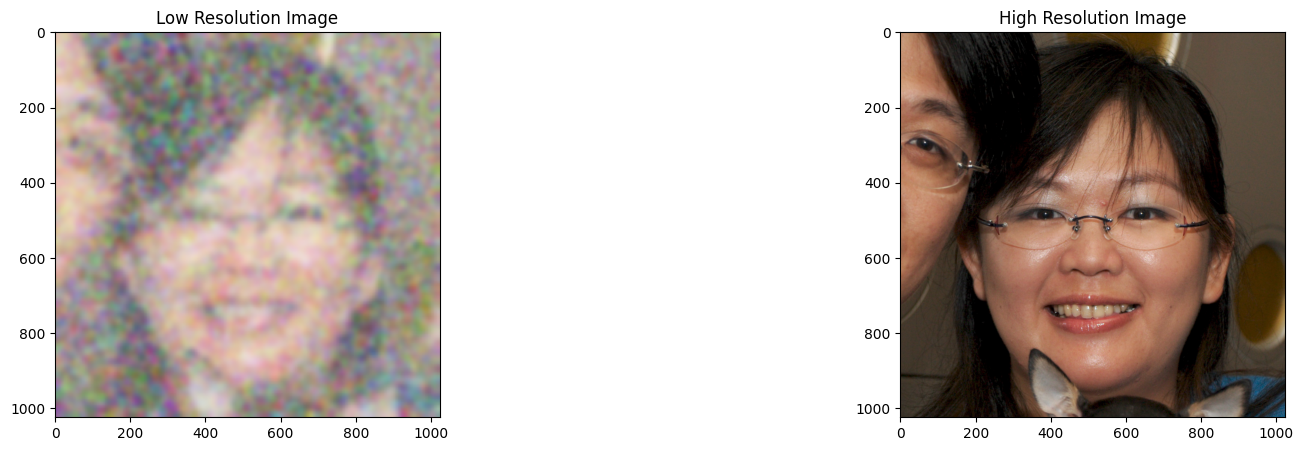

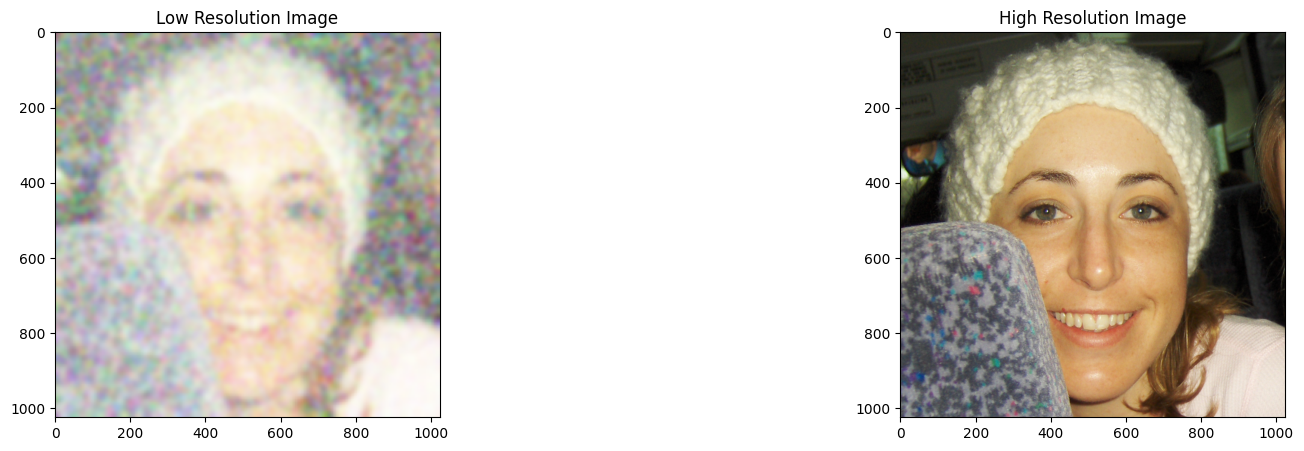

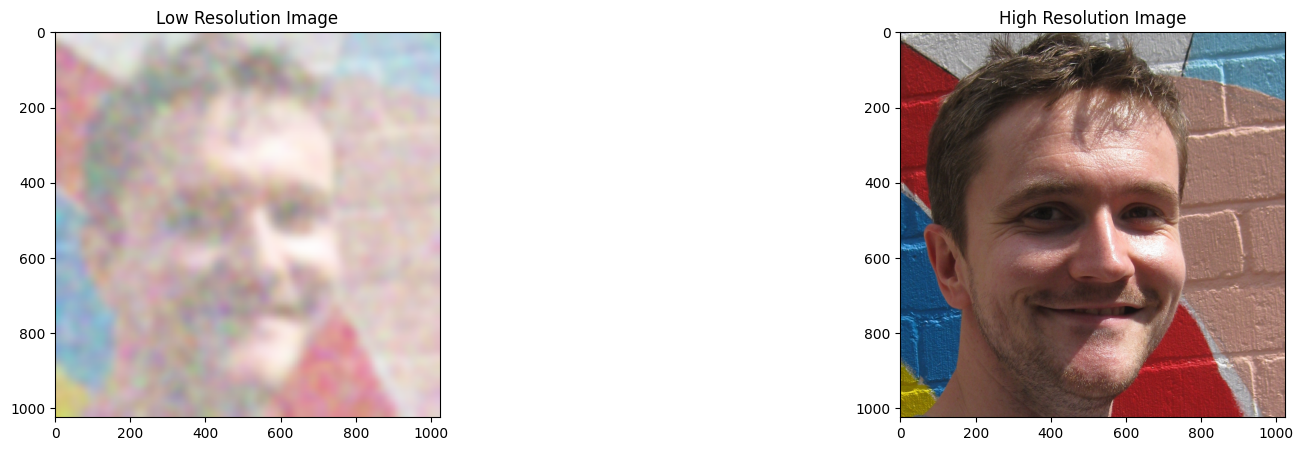

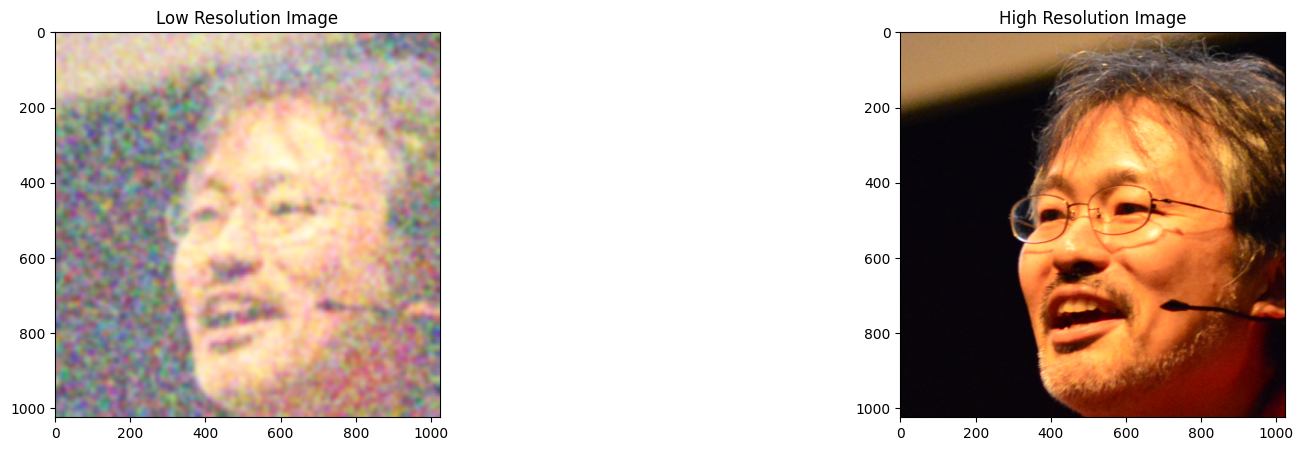

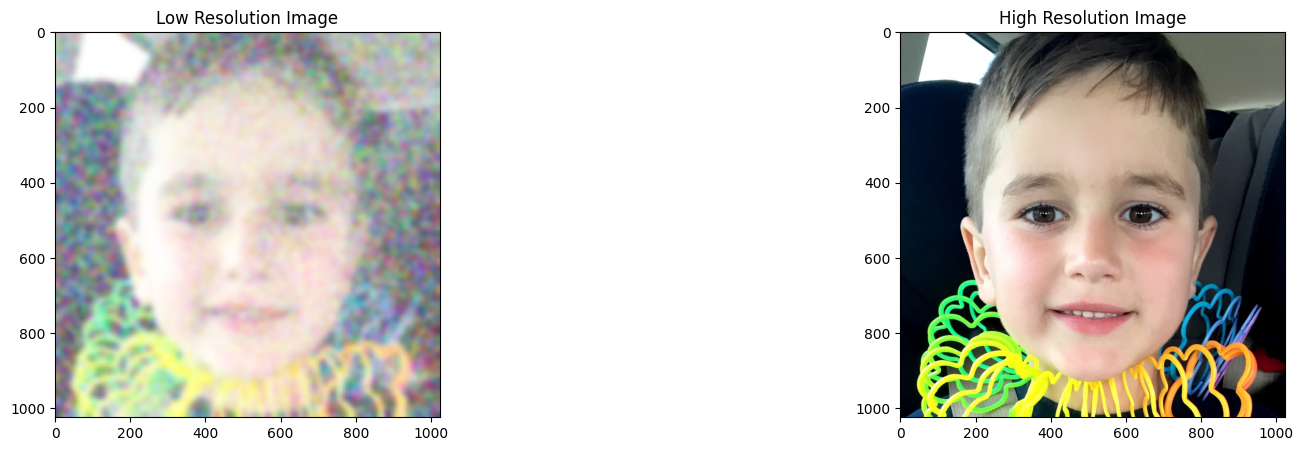

In [77]:
n = 0
for i,m in train_generator:
    img,out = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,5))
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(out[0])
        axs[1].set_title('High Resolution Image')
        plt.show()
        n+=1
    else:
        break

In [78]:
input_img = Input(shape=(1024, 1024, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu')(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu')(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu')(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu')(l6)

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu')(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu')(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu')(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu')(l13)

l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding='same', activation='relu')(l15)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [79]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 1024, 1024,   1792        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 1024, 1024,   36928       ['conv2d_20[0][0]']              
                                64)                                                         

In [80]:
train_samples = train_hiresimage_generator.samples
val_samples = val_hiresimage_generator.samples

train_img_gen = imageGenerator(train_generator)
val_image_gen = imageGenerator(val_generator)

In [81]:
model_path = "autoencoder.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 9,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [82]:
hist = autoencoder.fit(train_img_gen,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=val_image_gen,
                    validation_steps=val_samples//batch_size,
                    epochs=10, callbacks=[earlystop, checkpoint, learning_rate_reduction])

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/conv2d_25/Relu' defined at (most recent call last):
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\PPedro\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "C:\Users\PPedro\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\PPedro\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\PPedro\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\PPedro\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\PPedro\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\PPedro\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\PPedro\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\PPedro\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\PPedro\AppData\Local\Temp\ipykernel_13356\3196656175.py", line 1, in <module>
      hist = autoencoder.fit(train_img_gen,
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\PPedro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_2/conv2d_25/Relu'
OOM when allocating tensor with shape[2,256,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/conv2d_25/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4615]